In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from WaveModel import wave_transform # 自定义小波分析库
import requests
import talib

from EDC import QueryMacroIndic # 宏观数据获取 这里仅引用：社会融资规模同比数据
from typing import Tuple
import datetime as dt
from tqdm import *
from jqdata import *

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.gridspec as mg # 不规则子图
pd.plotting.register_matplotlib_converters()

# 设置字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family']='serif' # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

# Tsharpe模型演变过程

Robert Whitelaw（1994）中设定模型：
>four explanatory variables-the Baa-Aaa spread,the commercial paper-Treasury spread,the one-year Treasury yield,and the dividend yield

$$r_{t,t+r}=X_t\beta+u_{r+r}$$
$$\sqrt{\frac{\pi}{2}}|\hat{u}_{t+r}|=X_t\gamma+\epsilon_{t+r}$$

Robert Whitelaw（1997）中设定模型：

>The Baa-Aaa spread, the dividend yield, and the one-year yield are used in the mean equation, and the one-year yield and the commercialpaper-Treasury spread are used in the volatility equation.

$$R_{t+1}-R_{ft}=X_1t\beta_1+\epsilon_{1t+1}$$
$$\sqrt{\frac{\pi}{2}}|\epsilon_{1t+1}|=X_2t\beta_2+\epsilon_{2t+1}$$


***国信证券对上述解释变量做了更中国化的改变，具体如下：***

两个等式分别表达了对收益率和其波动性的回归。其中$R_{t+1}$指数收益,$R_{ft}$表示无风险利率,$X_{1t}$表示t期的[M1同比增长率,指数市盈率]和一年期国债利率组成的向量,而$X_{2t}$表示由在t期的一年期国债利率和[国债一年期即期收益率]组成的向量。


可以看到1994年模型与1997年模型的**不同**是：1994年两步回归时$X_t$表示的是同一解释变量；而1997年将解释变量拆成了两组分别为$X_1y$,$X_2t$;
**相同点：**都是将第一步回归后的残差带入第二步中作为被解释的变量。

在执行完两步回归后得到$\beta_1$,$\beta_2$后通过下述公式获取estimated conditional Sharpe ratio：

$$\hat{S}_t=\frac{X_{1t}\hat{\beta}_1}{X_{2t}\hat{\beta}_2}$$


# 构建数据提取函数

In [2]:
###################################### 数据获取及计算 ##############################################

# 货币(M1)供应量同比增长率


def GetMacro_M1(start_date: str, end_date: str) -> pd.DataFrame:
    '''
    start_date/end_date:YYYY-MM-dd
    '''
    # 获取M1同比
    q = query(macro.MAC_MONEY_SUPPLY_MONTH.stat_month,
              macro.MAC_MONEY_SUPPLY_MONTH.m1_yoy).filter(
                  macro.MAC_MONEY_SUPPLY_MONTH.stat_month >= start_date[:7],
                  macro.MAC_MONEY_SUPPLY_MONTH.stat_month <= end_date[:7])

    df = macro.run_query(q)
    
    df['stat_month'] = pd.to_datetime(GetTradePeriod(start_date, end_date))
    
    return df.set_index('stat_month')
    

# 获取指数月度收益
def GetIndexMRet(symbol:str,start_date:str,end_date:str)->pd.DataFrame:
    '''
    return
    ----------
        指数收盘价 月度收益率 月度波动率
    '''
    
    dates = pd.to_datetime(GetTradePeriod(start_date, end_date))
    
    index_price = get_price(
        symbol, start_date, end_date, fields=['close','pre_close'], panel=False)
    
    log_ret = np.log(index_price['close'] / index_price['pre_close']) # 对数收益率
    
    log_ret_m = log_ret.groupby(pd.Grouper(freq='M')).sum()
    close_m = index_price.groupby(pd.Grouper(freq='M'))['close'].last()
    sigma_m = log_ret.groupby(pd.Grouper(freq='M')).std()
    
    return pd.DataFrame({'log_ret':log_ret_m.values,'close':close_m.values,'sigma':sigma_m.values},index=dates)
    


# 手动计算指数PE 采用等权方式
def GetIndexPE(symbol: str, start_date: str, end_date: str,
               method: str = 'avg') -> pd.Series:
    '''method:avg mktcap 等权|加权'''

    trade_range = GetTradePeriod(start_date, end_date)

    pe_dict = {}  # 数据储存

    # 等权计算
    def _CalAvgPE(df: pd.DataFrame) -> float:

        return len(df) / np.sum(1 / df.query('pe_ratio > 0')['pe_ratio'])

    # 加权计算
    def _CalMktPE(df: pd.DataFrame) -> float:

        x_df = df.query('pe_ratio > 0')

        return df['circulating_market_cap'].sum() / (
            x_df['circulating_market_cap'] / x_df['pe_ratio']).sum()

    cal_fun = {'avg': _CalAvgPE, 'mktcap': _CalMktPE}[method]

    for d in trade_range:

        stocks = get_index_stocks(symbol, date=d)

        df = get_valuation(
            stocks,
            end_date=d,
            fields=['circulating_market_cap', 'pe_ratio'],
            count=1)

        pe_dict[d] = cal_fun(df)

    pe_ser = pd.Series(pe_dict)
    pe_ser.index = pd.to_datetime(pe_ser.index)

    pe_ser.name = 'PE'

    return pe_ser



# 查询指数
# 估值衍生 HS300,ZZ500等常规指数可用此函数
def GetIndexDerivative(symbol: str, start_date: str, end_date: str)->pd.DataFrame:
    '''
    返回 pe_ttm及指数股息率
    '''
    symbol = symbol[:-5]
    # 查询内部编码
    InnerCode_id = jy.run_query(
        query(jy.LC_IndexRelationship.InnerCode).filter(
            jy.LC_IndexRelationship.SecuCode == symbol))['InnerCode'][0]

    # 查询数据
    q = query(jy.LC_IndexDerivative.TradingDay,
              jy.LC_IndexDerivative.PE_TTM,jy.LC_IndexDerivative.DividendRatio).filter(
                  jy.LC_IndexDerivative.IndexCode == InnerCode_id,
                  jy.LC_IndexDerivative.TradingDay >= start_date,
                  jy.LC_IndexDerivative.TradingDay <= end_date)
    
    df = jy.run_query(q).set_index('TradingDay')
    dates = GetTradePeriod(start_date, end_date)
    df = df.reindex(dates)
    return df



# 即期收益率
## 计算银行间市场国债即期收益率 不确定算法是否正确
def GetInterestRate(start_date: str, end_date: str) -> pd.Series:

    trade = GetTradePeriod(start_date, end_date)

    bond_df = QueryBoudData(start_date, end_date)

    coupon = np.zeros(len(trade))

    for i, d in enumerate(trade):

        diff_ = (bond_df['coupon_end_date'] - d).dt.days

        cond = (diff_ >= 200) & (diff_ <= 366)

        cond = cond[cond == True]

        coupon_ser = bond_df.groupby(cond)['coupon'].mean()

        if coupon_ser.empty:

            coupon[i] = coupon[i - 1]

        else:
            coupon[i] = coupon_ser.values[0]

    COUPON = pd.Series(coupon, index=pd.to_datetime(trade))
    COUPON.name = 'COUPON'
    return COUPON


# 1年期即期收益率 不确定算法是否正确
## 银行间 国债 
def QueryBoudData(start_date: str, end_date: str) -> pd.DataFrame:

    bond_basic_info = bond.run_query(
        query(bond.BOND_BASIC_INFO.code, bond.BOND_BASIC_INFO.short_name,
              bond.BOND_BASIC_INFO.interest_begin_date,
              bond.BOND_BASIC_INFO.maturity_date).filter(
                  bond.BOND_BASIC_INFO.bond_type == "国债",
                  bond.BOND_BASIC_INFO.exchange == "银行间债券市场",
                  bond.BOND_BASIC_INFO.maturity_date >= start_date,
                  bond.BOND_BASIC_INFO.maturity_date <= end_date))

    bond_basic_info = bond_basic_info.sort_values('interest_begin_date')
    code = bond_basic_info['code'].unique().tolist()

    q_coupon = query(bond.BOND_COUPON.code, bond.BOND_COUPON.short_name,
                     bond.BOND_COUPON.coupon,
                     bond.BOND_COUPON.coupon_start_date,
                     bond.BOND_COUPON.coupon_end_date).filter(
                         bond.BOND_COUPON.code.in_(code),
                         bond.BOND_COUPON.coupon_end_date >= start_date,
                         bond.BOND_COUPON.coupon_end_date <= end_date)

    return bond.run_query(q_coupon)

# 获取1年期国债收益率
## 数据最早位2006-03-20 获取每月初到期收益
def Get_Bond_yield(start_date:str,end_date:str,frequency:float=1,is_end:bool=False)->pd.DataFrame:
    '''
    is_end：
        True  月末收益率为本月收益率
        False 使用月初国债到期收益率为本月的收益率
    '''
    df = query_bond_yield(start_date,end_date,frequency,'hzsylqx')
    df.columns = ['n','date','yeild']
    df.index = pd.to_datetime(df['date'])
    
    # 获取月初时点
    dates = GetTradePeriod(start_date,end_date,{False:'MS',True:'ME'}[is_end])
    e_dates = pd.to_datetime(GetTradePeriod(start_date,end_date,'ME'))
    df = df.reindex(dates)
    
    df.index = e_dates
    
    return df['yeild'].to_frame(f'Bond_yield_{frequency}y')


def bond_china_yield(start_date:str, end_date:str,gjqx:int,qxId:str="hzsylqx"):
    """
    中国债券信息网-国债及其他债券收益率曲线
    https://www.chinabond.com.cn/
    http://yield.chinabond.com.cn/cbweb-pbc-web/pbc/historyQuery?startDate=2019-02-07&endDate=2020-02-04&gjqx=0&qxId=ycqx&locale=cn_ZH
    注意: end_date - start_date 应该小于一年
    :param start_date: 需要查询的日期, 返回在该日期之后一年内的数据
        gjqx 为收益率的年限
    hzsylqx是中债登国债收益曲线、syyhsylqx是中债登商业银行普通债收益率曲线、zdqpjsylqx是中债登短期票据收
    :type start_date: str
    :param end_date: 需要查询的日期, 返回在该日期之前一年内的数据
    :type end_date: str
    :return: 返回在指定日期之间之前一年内的数据
    :rtype: pandas.DataFrame
    """
    url = "http://yield.chinabond.com.cn/cbweb-pbc-web/pbc/historyQuery"
    params = {
        "startDate": start_date,
        "endDate": end_date,
        "gjqx": str(gjqx),
        "qxId": qxId,
        "locale": "cn_ZH",
    }
    headers = {
        "User-Agent":
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36",
    }
    res = requests.get(url, params=params, headers=headers)
    data_text = res.text.replace("&nbsp", "")
    data_df = pd.read_html(data_text, header=0)[1]
    return data_df


def query_bond_yield(start_date: str, end_date: str,periods:int,bond_type:str):
    '''
    periods:债券期限
    bond_type:债券类型
    '''
    dates = get_trade_days(start_date, end_date)
    n_days = len(dates)
    limit = 244

    if n_days > limit:

        n = n_days // limit
        df_list = []
        i = 0
        pos1, pos2 = n * i, n * (i + 1) - 1
        while pos2 < n_days:
            #print(pos2)
            df = bond_china_yield(start_date=dates[pos1], end_date=dates[pos2],gjqx=periods,qxId=bond_type)
            df_list.append(df)
            i += 1
            pos1, pos2 = n * i, n * (i + 1) - 1

        if pos1 < n_days:
            df = bond_china_yield(start_date=dates[pos1], end_date=dates[-1],gjqx=periods,qxId=bond_type)
            df_list.append(df)
        df = pd.concat(df_list, axis=0)
    else:
        df = bond_china_yield(start_date=start_date, end_date=end_date,gjqx=periods,qxId=bond_type)

    return df.dropna(axis=1)

################################# 工具 #########################################


# 获取年末季末时点
def GetTradePeriod(start_date: str, end_date: str, freq: str = 'ME') -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月末，Q季末,Y年末 默认ME E代表期末 S代表期初
    ================
    return  list[datetime.date]
    '''
    days = pd.Index(pd.to_datetime(get_trade_days(start_date, end_date)))
    idx_df = days.to_frame()
    
    if freq[-1] == 'E':
        day_range = idx_df.resample(freq[0]).last()
    else:
        day_range = idx_df.resample(freq[0]).first()

    day_range = day_range[0].dt.date

    return day_range.dropna().values.tolist()


# 显示数据分布
def Plot_SingalForwardReturnsDistribution(singal_ser: pd.DataFrame,
                                          close_ser: pd.DataFrame):

    test = pd.concat([singal_ser, close_ser.pct_change().shift(-1)], axis=1)
    test = test.dropna()
    test.columns = ['singal', 'next_ret']

    v = pd.cut(test['singal'], bins=50)
    test['group'] = v

    mean_ret = test.groupby('group')['next_ret'].mean()

    plt.rcParams['font.family'] = 'serif'
    plt.figure(figsize=(18, 6))

    # 用于设置不规则子图
    gs = mg.GridSpec(1, 3)

    # 子图-信号分布
    plt.subplot(gs[0, 0])
    plt.title('信号分布')
    sns.distplot(singal_ser.dropna())

    plt.axvline(singal_ser.mean(), ls='--', color='r', alpha=0.5, label='mean')

    plt.axvline(
        singal_ser.mean() + 2 * singal_ser.std(),
        ls='--',
        color='black',
        alpha=0.5,
        label='2std')

    plt.axvline(
        singal_ser.mean() - 2 * singal_ser.std(),
        ls='--',
        color='black',
        alpha=0.5,
        label='-2std')

    plt.legend()

    # 子图-信号与下期平均收益
    plt.subplot(gs[0, 1:3])
    plt.title('信号与下期平均收益')

    # 设置标签
    labels = mean_ret.index
    # 大于0
    a = np.where(mean_ret >= 0, mean_ret, 0)
    # 小于0
    b = np.where(mean_ret < 0, mean_ret, 0)
    plt.bar(range(len(a)), a, tick_label=labels, color='r')
    plt.bar(range(len(b)), b, tick_label=labels, color='green')
    # 标签旋转
    plt.xticks(rotation=90)
    plt.show()


# 直接估计时变夏普

上述的这种模型虽然能对经济数据起到较好的预测，可是仍有不足，譬如该模型需要通过两次估算才能得到关于时变夏普率的解释变量的系数，这样相对的误差可能会比较大，于是Whitelaw（1997）直接根据夏普率的定义对其进行计算
>One feasible alternative is to employ more frequently sampled data (e.g., daily data) to estimate monthly volatility.Specifically, monthly ratios are computed as: 
$$S_{t+1} = \frac{R_{t+1}-R_{ft}}{\sigma_{t+1}}$$
>
>$$\sigma_{t+1}=\sqrt{\sum^{N}_{n-1}R^{2}_{T+n}}$$
>where n indexes the daily returns within month t+1

得到$S_{t+1}$后带入下面的回归方程：
$$S_{t+1}=X_t\beta+\epsilon_{t+1}$$

在国信研报中前半部分直接使用$S_{t+1}$作为信号进行分析,之后才用了回归方程进行测试。

In [3]:
# 利用 Robert Whitelaw（1997）给出的直接估算模型计算Tsharpe
#  Estimating Sharpe Ratios Directly

def EstimatingSharpeRatiosDirectly(symbol: str, start_date: str, end_date: str) -> pd.Series:
    '''
    使用1年期国债到期收益率充当无风险收益率
    ------------
    return 返回频率为月度的指标值
    '''
    
    idx = pd.Index(GetTradePeriod(start_date, end_date))
    
    df = get_price(
        symbol,
        start_date,
        end_date,
        fields=['close', 'pre_close'],
        panel=False)
    
    ret = np.log(df['close'] / df['pre_close'])
    
    m_r = ret.groupby(pd.Grouper(freq='M')).sum()
    
    # 无风险收益率设置
    r_f = 0.03
    
    r_e = m_r - r_f
    
    # 计算月度标准差
    m_std = ret.groupby(
        pd.Grouper(freq='M')).apply(lambda x:np.sqrt(x @ x))
    
    
    
    ESRD = r_e / m_std
    
    ESRD.index = pd.to_datetime(idx)
    ESRD.name = 'EstimatingSharpeRatiosDirectly'

    return ESRD

In [6]:
symbol = '399311.XSHE'

start_date,end_date = '2006-05-01','2020-05-31'


# 使用直接估算模型取得share
ESRD = EstimatingSharpeRatiosDirectly('399311.XSHE',start_date,end_date)

# 获取指数收益率
price_df = get_price('399311.XSHE',start_date,end_date,fields='close')

# 月度收盘价
M_close = price_df.reindex(ESRD.index)


这里可以很清楚的看出，当夏普率在高点的时候，指数基本都会上涨，相反当夏普率在低点的时候，指数也基本会下跌。可以很好的看出时变夏普率对于指 数的判断力，这是由于夏普率的定义，也就是单位风险所产生的超额收益所带来的效果。

*指数与直接估计的夏普整体走势情况*

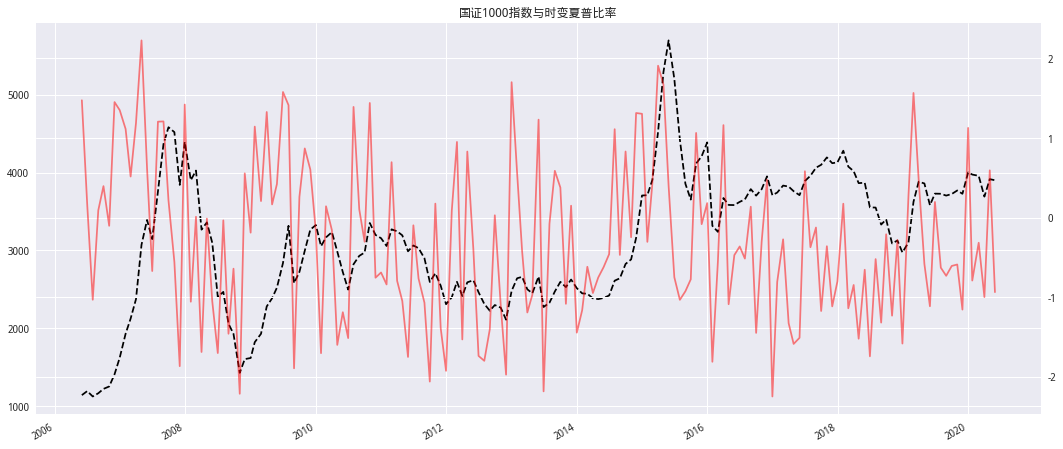

In [7]:
# 查看整体走势
plt.rcParams['font.family']='serif'
M_close['close'].plot(figsize=(18,8),title='国证1000指数与时变夏普比率',color='black',ls='--')
plt.twinx()
ESRD.plot(color='red',alpha=0.5)

*指数与直接估计的夏普细节部分的走势情况*

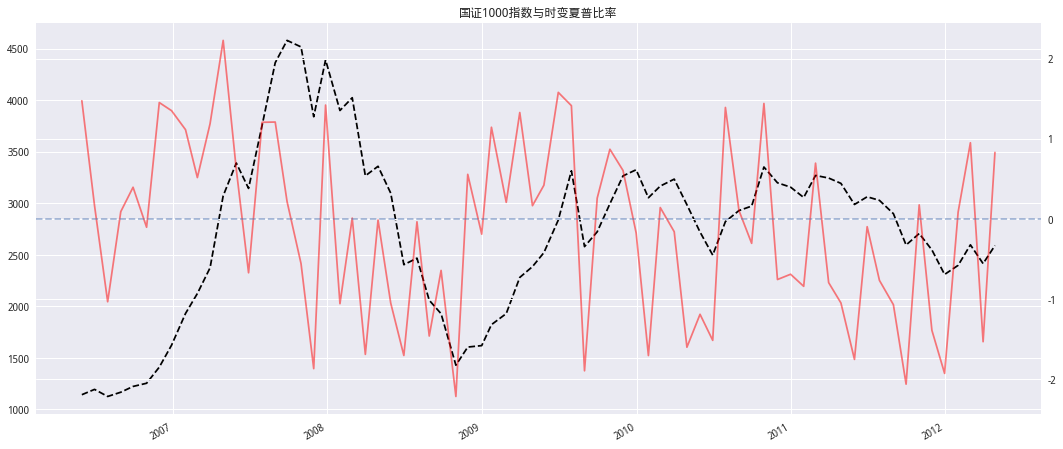

In [8]:
# 查看走势细节
slice_close = M_close.loc[dt.date(2005, 5, 31):dt.date(2012, 5, 1)]
slice_esrd = ESRD.loc[dt.date(2005, 5, 31):dt.date(2012, 5, 1)]

slice_close['close'].plot(figsize=(18,8),title='国证1000指数与时变夏普比率',color='black',ls='--')
plt.twinx()
slice_esrd.plot(color='red',alpha=0.5)
plt.axhline(0,ls='--',alpha=0.5)

当时变夏普率在接近 0的时候，指数是处于一个相对平稳的状态，而时变夏普率的绝对值越大，指数的波动同样也越大。于是设定两个参 数，-0.3与 0.3，其中当时变夏普率小于-0.3的时候，持有现金，大于 0.3时将持有指数，而介于-0.3 与 0.3 之间的，则不进行买卖。

In [4]:
# 持仓标记
def Add_Flag(singal: pd.Series, threshold: Tuple[float, float]) -> pd.Series:
    '''
    singal:信号值
    threshold:(开仓阈值，平仓阈值)
    -------------------
    return
        1持仓0空仓
    '''

    a = threshold[0]  # 开仓阈值
    b = threshold[1]  # 平仓阈值

    flag = np.zeros(len(singal))
    for i, e in enumerate(singal):

        if e > a:

            flag[i] = 1

        elif b <= e <= a and flag[i - 1] == 1:

            flag[i] = 1

        else:

            flag[i] = 0

    return pd.Series(flag, index=singal.index)

可以看到通过直接估计的时变夏普，在16年依旧有较大的回撤

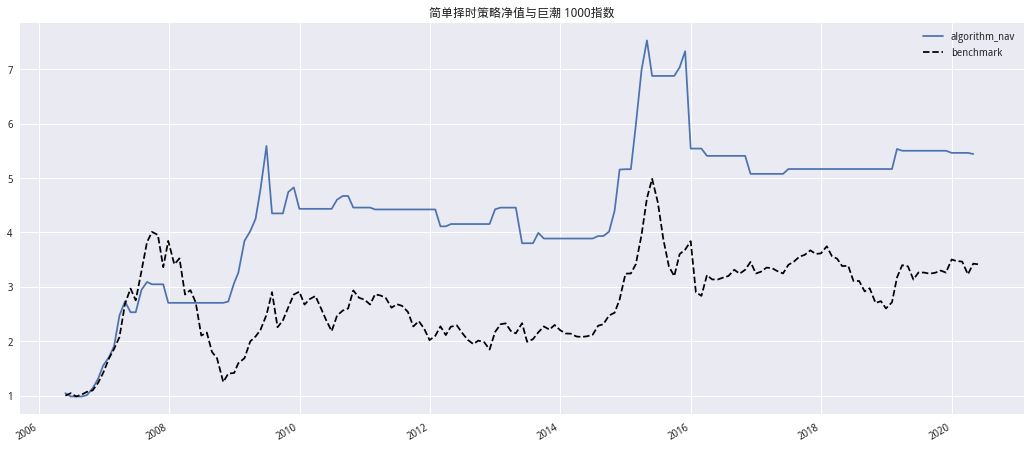

In [10]:
flag = Add_Flag(ESRD,(0.3,-0.3))

next_ret = M_close['close'].pct_change().shift(-1)

(1 + flag * next_ret).cumprod().plot(figsize=(18,8),
                                     title='简单择时策略净值与巨潮 1000指数',
                                     label='algorithm_nav')

(M_close['close'] / M_close['close'][0]).plot(label='benchmark',
                                              color='black',ls='--')

plt.legend()
plt.show()

对直接估算的时变夏普进行小波处理,信号更具有趋势性

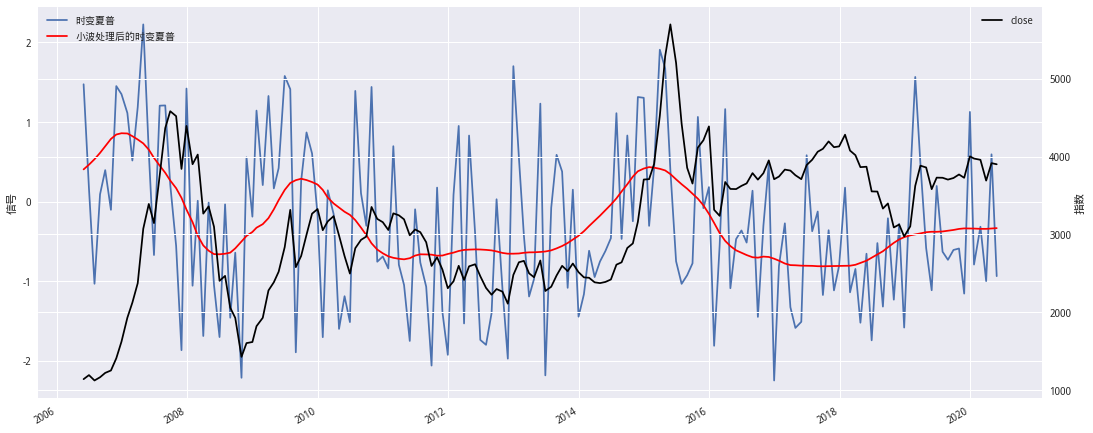

In [42]:
# 对直接时变夏普进行小波处理
t_esrd = wave_transform(ESRD,'db4','symmetric',4,'sqtwolog',1,4)

ESRD.plot(figsize=(18,8))
t_esrd.plot(color='red')
plt.ylabel('信号')
plt.legend(['时变夏普','小波处理后的时变夏普'],loc='upper left')
plt.twinx()
M_close['close'].plot(color='black')
plt.ylabel('指数')
plt.legend(['close'])

大段时间未开仓，2016年回撤依旧很大

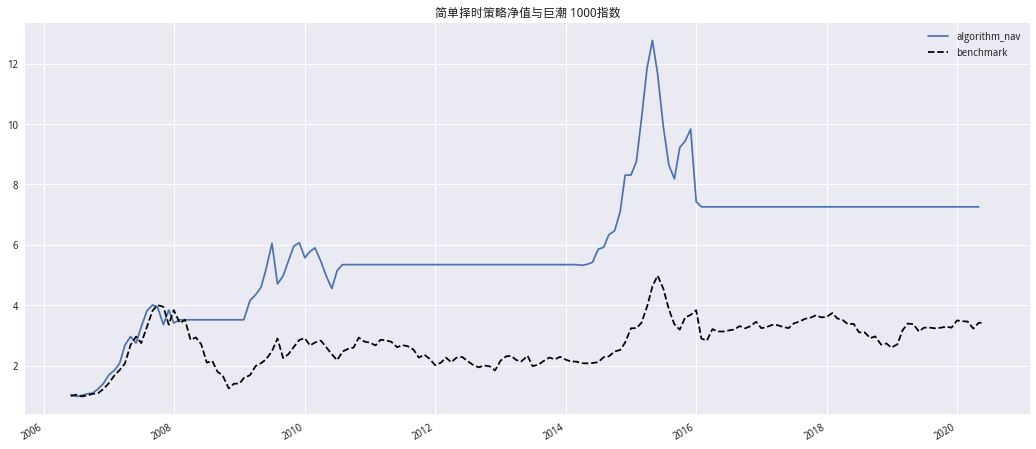

In [41]:
flag = Add_Flag(t_esrd,(-0.3,0.3))

next_ret = M_close['close'].pct_change().shift(-1)

(1 + flag * next_ret).cumprod().plot(figsize=(18,8),
                                     title='简单择时策略净值与巨潮 1000指数',
                                     label='algorithm_nav')

(M_close['close'] / M_close['close'][0]).plot(label='benchmark',
                                              color='black',ls='--')

plt.legend()
plt.show()

直接用时变夏普率作为策略指标就已经可以得到超过指数将近一倍的超额收益， 现在将M1同比增长率，标的指数的市盈率以及一年期的银行间国债即期收益 率作为解释变量，由于这些月度经济数据的获取时间比较靠后，比如当月的 M1 同比增长率中国人民银行官方数据一般要到下月的月中或者月末才会发布，我 们很难在月初获取上月的经济数据，因此无法及时的获得下月的预测时变夏普 率，所以这里我们尝试用上月的经济数据对下月的时变夏普率进行预测，将Whitelaw（1997）所给出的回归方程：

$$S^*_{t+1}=X_t\beta+\epsilon_{t+1}$$

改进为：

$$S^*_{t+1}=X_{t-1}\beta+\epsilon_{t+1}$$

In [11]:
# 回归所需数据
def QueryData(symbol: str, start_date: str, end_date: str) -> pd.DataFrame:
    '''
    return
    ----------------------
        M1同比增长 
        指数PE 
        指数收益率 
        银行间国债即期收益率 
        1年期国债到期收益率
    '''
    M1 = GetMacro_M1(start_date, end_date) / 100

    PE = GetIndexPE(symbol, start_date, end_date)
    
    M_RET = GetIndexMRet(symbol, start_date, end_date)
    
    Interest_ret = GetInterestRate(start_date, end_date) / 100
    
    yeild_1Y = Get_Bond_yield(start_date,end_date,is_end=True) / 100
    
    return pd.concat([M1, PE, M_RET, Interest_ret, yeild_1Y], axis=1)

In [183]:
# 获取回归所需数据
x_df = QueryData('399311.XSHE',start_date,end_date)

conditioning_variables = pd.concat([x_df.shift(-1),ESRD],axis=1) # 对齐数据

conditioning_variables = conditioning_variables.iloc[:-1] # 最后一行为NA股过滤

# 数据储存
conditioning_variables.to_csv('../Data/Tshare_conditioning_variables.csv')

conditioning_variables.head()

,m1_yoy,PE,log_ret,close,sigma,COUPON,Bond_yield_1y,EstimatingSharpeRatiosDirectly
stat_month,,,,,,,,
2006-05-31,0.130,34.203235,0.044203,1194.73,0.018602,0.026293,0.020100,1.771089
2006-06-30,0.140,31.559782,-0.059302,1125.94,0.019145,0.026614,0.022300,0.515393
2006-07-31,0.140,30.882870,0.036041,1167.26,0.013838,0.027862,0.020310,-0.684840
2006-08-31,0.153,31.619369,0.046877,1223.28,0.009242,0.033744,0.020159,0.551584
2006-09-29,0.150,30.235148,0.024970,1254.21,0.012198,0.033759,0.020104,1.100899


In [12]:
# 读取数据
conditioning_variables = pd.read_csv('../Data/Tshare_conditioning_variables.csv',index_col=0,parse_dates=True)

In [13]:
x = conditioning_variables['m1_yoy,PE,COUPON'.split(',')]
y = conditioning_variables['EstimatingSharpeRatiosDirectly']
X = sm.add_constant(x)
model = sm.OLS(y,X)
result = model.fit()

print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     EstimatingSharpeRatiosDirectly   R-squared:                   -1695.134
Model:                                        OLS   Adj. R-squared:              -1726.161
Method:                             Least Squares   F-statistic:                    -54.63
Date:                            Tue, 28 Jul 2020   Prob (F-statistic):               1.00
Time:                                    14:59:19   Log-Likelihood:                -868.02
No. Observations:                             168   AIC:                             1744.
Df Residuals:                                 164   BIC:                             1757.
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

# 滚动回归预测时变夏普比率


In [37]:
# 定义rolling_apply理论上应该比for循环快
# pandas.rolling.apply不支持多列
def rolling_apply(df, func, win_size) -> pd.Series:

    iidx = np.arange(len(df))
    
    shape = (iidx.size - win_size + 1, win_size)
    
    strides = (iidx.strides[0], iidx.strides[0])
    
    res = np.lib.stride_tricks.as_strided(
        iidx, shape=shape, strides=strides, writeable=True)

    # 这里注意func返回的需要为df或者ser
    return pd.concat((func(df.iloc[r]) for r in res), axis=0)  # concat可能会有点慢

# 滚动估计
def iter_rolling_window(df:pd.DataFrame,cal_func,x_col:list,y_col:str)->pd.Series:
    
    df = pd.concat([rolling_apply(df,lambda x:cal_func(x,x_col,y_col),i + 1) for i in [20,30,40,50]],axis=1,sort=True)
    df.columns = [str(i) for i in [20,30,40,50]]
    
    return df 

################################################ two-step OLS ###########################################
'''
Robert Whitelaw 提出的两步回归模型
'''
# Robert Whitelaw（1994）模型
def CalTsharpe_1(df:pd.DataFrame,x_col:list,y_col:str)->pd.Series:
    
    y = df[y_col].fillna(0)

    x = sm.add_constant(df[x_col].fillna(0))
    
    X = x.iloc[:-1]
    Y = y.iloc[:-1]

    # step 1:
    model_a = sm.OLS(Y,X).fit()
    BETA = model_a.params
    
    y_resid = np.sqrt(np.pi / 2) * np.abs(model_a.resid)
    
    # step 2:
    model_b = sm.OLS(y_resid,X).fit()
    GAMMA = model_b.params
    
    v = (x.iloc[-1].values @ BETA) / (x.iloc[-1].values @  GAMMA)
    
    return pd.Series(v,index = [df.index[-1]])
    
# 1997
def CalTsharpe_2(df:pd.DataFrame,x_col:Tuple[list,list],y_col:str)->pd.Series:
    
    x_1 = x_col[0]
    x_2 = x_col[1]
    
    x1_df =  df[x_1].fillna(0)
    x2_df =  df[x_2].fillna(0)
    
    y = df[y_col].iloc[:-1]
    
    X1 = sm.add_constant(x1_df)
    X2 = sm.add_constant(x2_df)
    # step 1:
    model_a = sm.OLS(y,X1.iloc[:-1]).fit()
    BETA = model_a.params
    
    y_resid = np.sqrt(np.pi / 2) * np.abs(model_a.resid)
    
    # step 2:
    model_b = sm.OLS(y_resid,X2.iloc[:-1]).fit()
    
    GAMMA = model_b.params
    
    v = (X1.iloc[-1].values @ BETA) / (X2.iloc[-1].values @  GAMMA)
    
    return pd.Series(v,index = [df.index[-1]])


####################################### 直接估计夏普的回归模型 #######################################

def CalTsharpe_3(df:pd.DataFrame,x_col:list,y_col:str)->pd.Series:
    
    x = sm.add_constant(df[x_col])
    y = df[y_col]
    
    model = sm.OLS(y.iloc[:-1],x.iloc[:-1])
    
    res = model.fit()
   
    return pd.Series(model.predict(res.params,x.iloc[-1]),index=[x.index[-1]])
    
    

## 直接估计夏普的回归模型

在国信证券的研报中所用模型

**参数变量设置**

标的指数:国证1000

使用Robert Whitelaw（1994）中设定模型解释变量为：

1. M1同比增长率;
2. 指数PE;
3. 一年期国债收益率;

In [15]:
# 读取数据
conditioning_variables = pd.read_csv('../Data/Tshare_conditioning_variables.csv',index_col=0,parse_dates=True)

# 计算指数超额收益
conditioning_variables['r_f'] = conditioning_variables['log_ret'] - 0.04

conditioning_variables.head()

,m1_yoy,PE,log_ret,close,sigma,COUPON,Bond_yield_1y,EstimatingSharpeRatiosDirectly,r_f
stat_month,,,,,,,,,
2006-05-31,0.130,34.203235,0.044203,1194.73,0.018602,0.026293,0.020100,1.771089,0.004203
2006-06-30,0.140,31.559782,-0.059302,1125.94,0.019145,0.026614,0.022300,0.515393,-0.099302
2006-07-31,0.140,30.882870,0.036041,1167.26,0.013838,0.027862,0.020310,-0.684840,-0.003959
2006-08-31,0.153,31.619369,0.046877,1223.28,0.009242,0.033744,0.020159,0.551584,0.006877
2006-09-29,0.150,30.235148,0.024970,1254.21,0.012198,0.033759,0.020104,1.100899,-0.015030


In [16]:
x_col = 'm1_yoy,PE,Bond_yield_1y'.split(',')
y_col = 'EstimatingSharpeRatiosDirectly'

estimated_conditional_sharpe = iter_rolling_window(
    conditioning_variables, CalTsharpe_3, x_col, y_col)

时变夏普实际值与滚动预测值

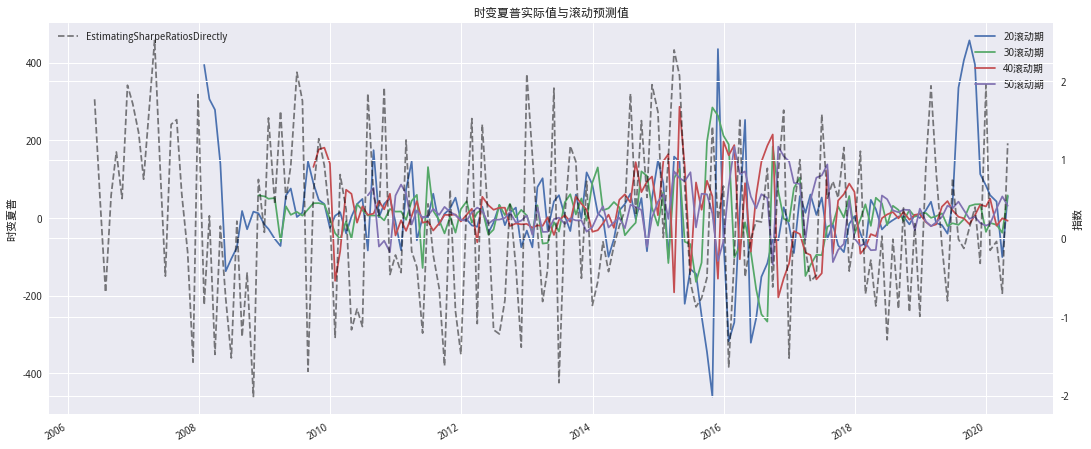

In [19]:
plt.rcParams['font.family'] = 'serif'

estimated_conditional_sharpe.plot(figsize=(18, 8), title='时变夏普实际值与滚动预测值')

plt.ylabel('时变夏普')

plt.legend([f'{i}滚动期' for i in estimated_conditional_sharpe.columns] +
           ['ESRD'], loc='upper right')

# 双y轴
plt.twinx()

conditioning_variables['EstimatingSharpeRatiosDirectly'].plot(
    color='black', ls='--', alpha=0.5)

plt.legend(loc='upper left')
plt.ylabel('指数')
plt.show()


滚动预测值与指数情况

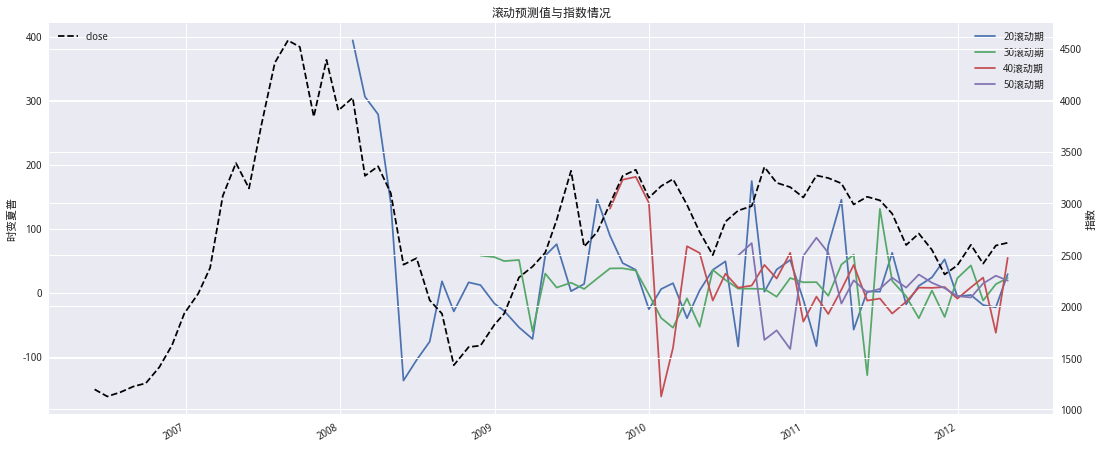

In [21]:
watch_range = pd.IndexSlice['2005-05-01':'2012-05-01']

estimated_conditional_sharpe.loc[watch_range].plot(figsize=(18,8),title='滚动预测值与指数情况')

plt.legend([f'{i}滚动期' for i in estimated_conditional_sharpe.columns] + ['ESRD'],loc='upper right')
plt.ylabel('时变夏普')
plt.twinx()
conditioning_variables.loc[watch_range,'close'].plot(color='black',ls='--',label='close')
plt.legend(loc='upper left')
plt.ylabel('指数')
plt.show()

滚动期为30个月开仓阈值为0.48,平仓阈值为0.24的收益情况如下:

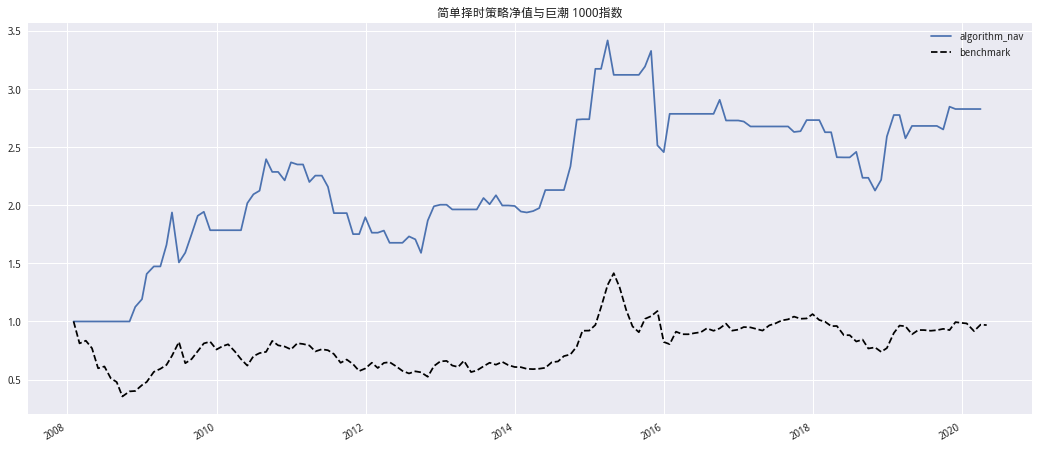

In [22]:
flag = Add_Flag(estimated_conditional_sharpe['30'],(0.48, 0.24)).dropna()
idx = flag.index
slice_df = conditioning_variables['close'].reindex(idx)
next_ret = slice_df.pct_change().shift(-1)

(1 + flag * next_ret).cumprod().plot(figsize=(18,8),
                                     title='简单择时策略净值与巨潮 1000指数',
                                     label='algorithm_nav')

(slice_df / slice_df[0]).plot(label='benchmark',
                                              color='black',ls='--')

plt.legend()
plt.show()

## 使用1994年的模型进行估计

在《国海证券-新量化择时指标之二 Tsharp》关于Tsharpe的具体处理中使用的是1994年的模型,研报中未说明具体使用的哪些数据作为解释变量，如果只是根据作者的只字片语进行挖掘,还不如直接机器学习,我尝试了下面几个参数作为解释变量,效果很差。

**参数变量设置**

标的指数:000001.XSHG

使用Robert Whitelaw（1994）中设定模型解释变量为：

1. M1同比增长率；
2. Baa-Aaa息差采用**中债企业债(AA)与国债利差**；
3. 一年期国债收益率;
4. 储蓄(由于研报中未说明具体是什么所以这里使用**国民总储蓄率**)

In [6]:
QMI = QueryMacroIndic() # 初始化接口

# 查看接口可查询字段
QMI.inidcId_dic

{'1070015614': '社会融资规模增量:当月同比',
 '1070000052': '社会融资规模增量:当月值',
 '1070015603': '社会融资规模增量:当月值:初值',
 '1070000007': '货币供应量:M1:同比',
 '1070000046': '货币供应量:M2:同比',
 '1040000702': 'PPI:当月同比',
 '1040000050': 'CPI:当月同比',
 '1070014164': '金融机构:新增人民币存款:非银行业金融机构:当月值',
 '1070014167': '金融机构:新增人民币存款:非银行业金融机构:累计值',
 '1070001424': '金融机构:本外币:股权及其他投资',
 '1070001820': '中资全国性四大银行:人民币:境内存款:个人:储蓄存款',
 '1070001771': '中资全国性大型银行:人民币:境内存款:个人:储蓄存款',
 '1030000011': '制造业PMI',
 'C81942': '存款准备金率:大型金融机构',
 'C81944': '国民总储蓄率',
 '1170007465': '沪深算数平均股息率(d)',
 '1170011506': '上海市场:股息率算术平均指标(d)',
 '1090001399': '十年期国债到期收益率(d)',
 '1090001390': '中债国债到期收益率:1年(d)',
 '1090002720': '中债企业债(AA)与国债利差:1年(d)',
 '1090000540': 'SHIBOR:1个月(d)',
 '1090001385': '中债国债到期收益率:1个月',
 '1080000566': '离岸人民币即期汇率(USD/CNH)(d)'}

In [7]:
# 模型所需数据获取
symbol = '000001.XSHG'

start_date,end_date = '2010-01-01','2020-06-30'

# 获取 数据
indic_df = QMI.GetFields(['1070000007','1090002720','1090001390','C81944'])

indic_df = indic_df.loc[start_date:end_date]
begin,end = min(indic_df.index),max(indic_df.index)

idx = GetTradePeriod(begin,end)

# 获取月末数据
Mindic_df = indic_df.resample('M').last().copy()
Mindic_df.index = pd.to_datetime(idx)

# 获取上证指数月度收益 收盘价 波动率
index_price = GetIndexMRet(symbol,begin,end)

# 计算无风险收益
index_price['r_f'] = index_price['log_ret'] - 0.04

# 合并数据
regress_df = pd.concat([Mindic_df,index_price[['r_f','close']]],axis=1)

# 查看数据结构
regress_df.head()

,货币供应量:M1:同比,中债企业债(AA)与国债利差:1年(d),中债国债到期收益率:1年(d),国民总储蓄率,r_f,close
2010-01-29,38.96,1.8686,1.6529,4.264167,-0.131935,2989.29
2010-02-26,34.99,1.8447,1.6294,4.264167,-0.019258,3051.94
2010-03-31,29.94,1.6851,1.5501,4.264167,-0.021441,3109.11
2010-04-30,31.25,1.6948,1.5892,4.264167,-0.119812,2870.61
2010-05-31,29.90,1.3471,1.8162,4.264167,-0.142037,2592.15


In [8]:
x_col = '货币供应量:M1:同比,中债企业债(AA)与国债利差:1年(d),中债国债到期收益率:1年(d),国民总储蓄率'.split(',')
y_col = 'r_f'
regress_df.loc[:,x_col] = regress_df[x_col] / 100

查看各解释变量与指数的关系

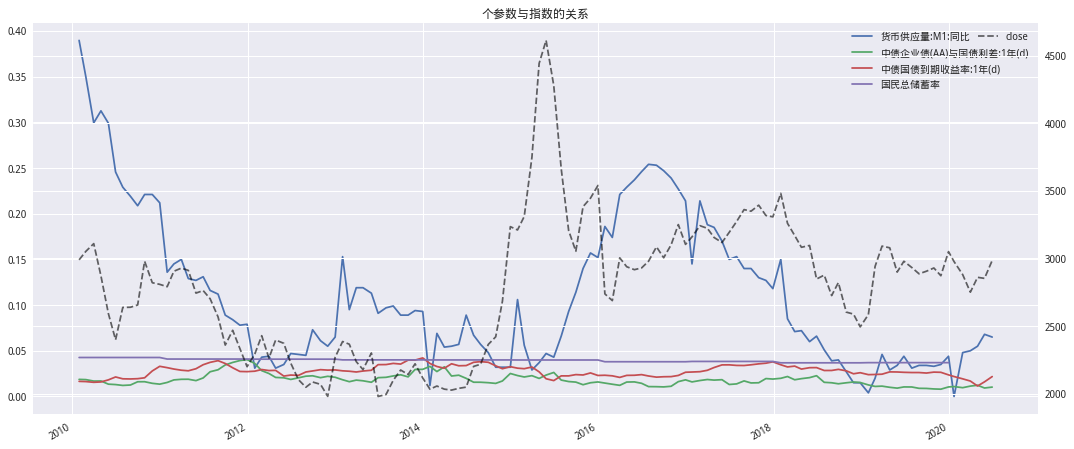

In [21]:
regress_df.loc[:,x_col].plot(figsize=(18,8),title='各参数与指数的关系')
plt.twinx()
regress_df['close'].plot(color='black',alpha=0.6,ls='--')
plt.legend(['close'],loc='upper right')

滚动时变夏普的整体趋势情况

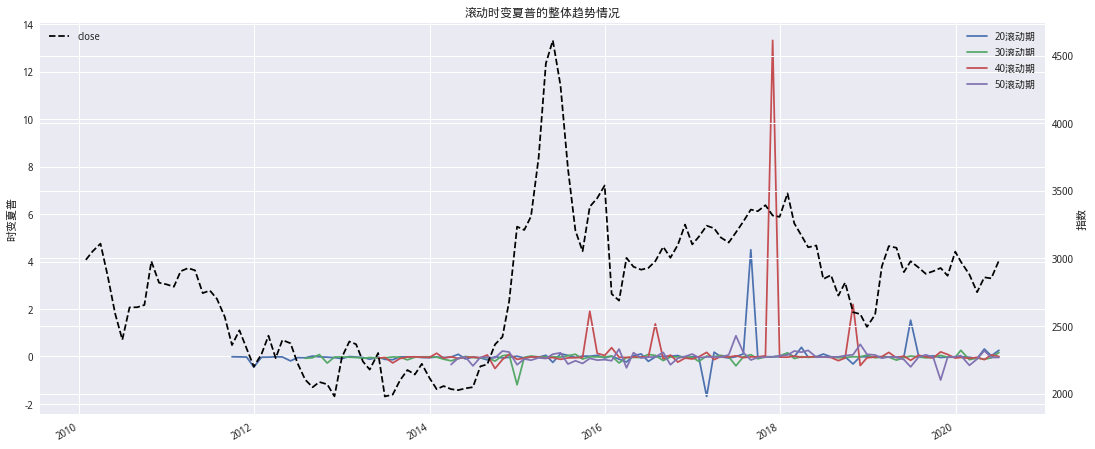

In [38]:
sharpe_1 = iter_rolling_window(regress_df,CalTsharpe_1,x_col,y_col)

plt.rcParams['font.family']='serif'
sharpe_1.plot(figsize=(18,8),title='滚动时变夏普的整体趋势情况')


plt.legend([f'{i}滚动期' for i in sharpe_1.columns],loc='upper right')
plt.ylabel('时变夏普')
plt.twinx()
regress_df['close'].plot(color='black',ls='--',label='close')
plt.legend(loc='upper left')
plt.ylabel('指数')
plt.show()

局部细节情况

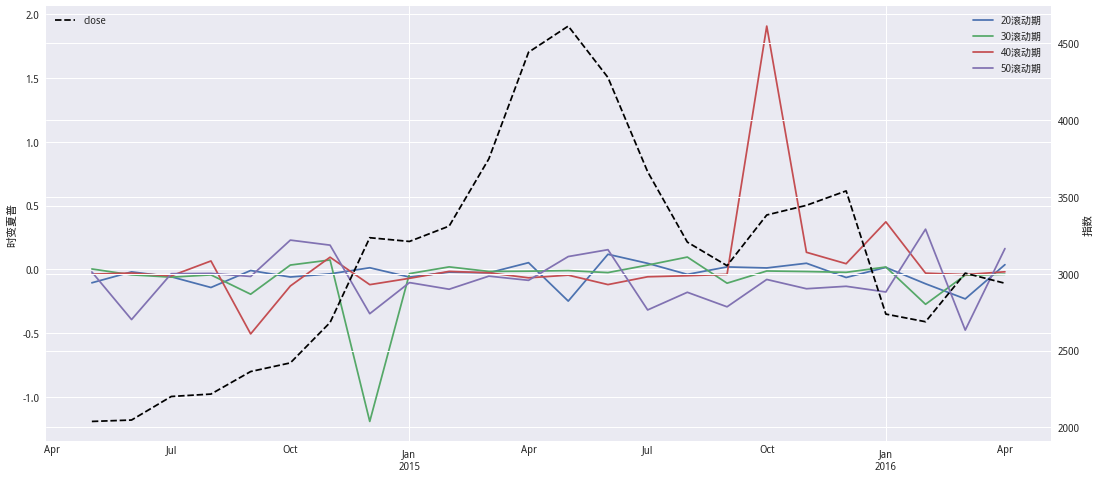

In [39]:
watch_range = pd.IndexSlice['2014-05-01':'2016-05-01']

sharpe_1.loc[watch_range].plot(figsize=(18,8))


plt.legend([f'{i}滚动期' for i in sharpe_1.columns] + ['ESRD'],loc='upper right')
plt.ylabel('时变夏普')
plt.twinx()
regress_df.loc[watch_range,'close'].plot(color='black',ls='--',label='close')
plt.legend(loc='upper left')
plt.ylabel('指数')
plt.show()

各滚动周期Tsharp值与上证综指超额收益的相关系数分别为

In [62]:
corr_v = sharpe_1.corrwith(regress_df.reindex(sharpe_1.index)['r_f'])
for windows,corr in corr_v.items():
    print('滚动周期为%s个月与上证超额收益相关系数为%.2f'%(windows,corr))

滚动周期为20个月与上证超额收益相关系数为0.04
滚动周期为30个月与上证超额收益相关系数为-0.25
滚动周期为40个月与上证超额收益相关系数为-0.06
滚动周期为50个月与上证超额收益相关系数为-0.01


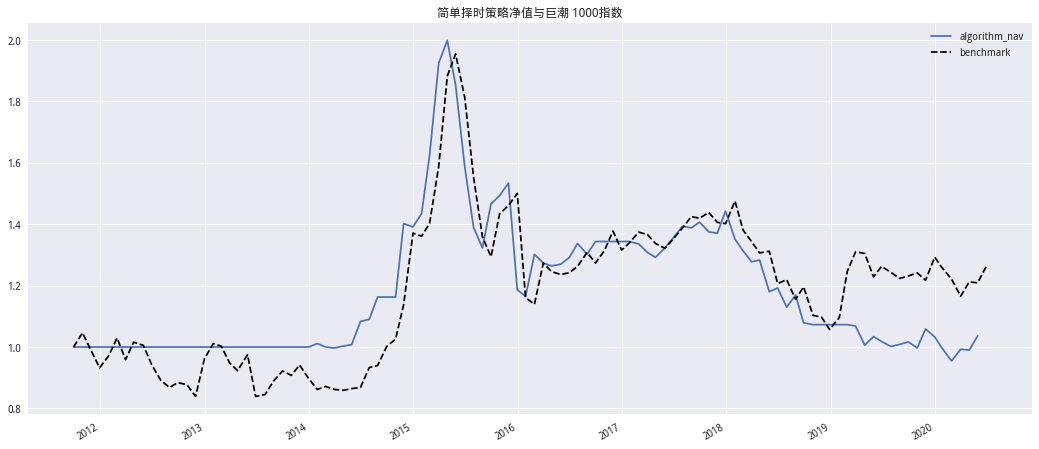

In [78]:
flag = Add_Flag(sharpe_1['40'],(0., -0.2)).dropna()
idx = flag.index
slice_df = regress_df['close'].reindex(idx)
next_ret = slice_df.pct_change().shift(-1)

(1 + flag * next_ret).cumprod().plot(figsize=(18,8),
                                     title='简单择时策略净值与巨潮 1000指数',
                                     label='algorithm_nav')

(slice_df / slice_df[0]).plot(label='benchmark',
                                              color='black',ls='--')

plt.legend()
plt.show()